## **Gerekli Kütüphanelerin Kurulumu ve Aktarılması**

* **Pandas**, **numpy** python'da veri işleme, veri okuma, sayısal işlemler ve matematiksel hesaplamalar için kullanılır.(Her projede olmazsa olmaz diyebileceğimiz kütüphanelerdir.)
* **Matplotlib**, **PIL** ve **Seaborn** kütüphanesi veri görselleştirme, grafiksel işlemlerde kullanılır.
* **Tensorflow**, modelimizi oluşturacağımız ve eğitim, test vb. bir sürü alanda kullanabileceğimiz geniş çalışma alanı sunan bir kütüphanedir.(Google tarafından geliştirilmiştir.)
* **sklearn**, bu projede etiketleri kategorileştirmek için ve veri setimizi ayırmak için kullandık.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization
import matplotlib.image as mpimg

Bazen matplotlib olsun bazı kısımlarda "warning" çıkıyor onu bu şekilde filtreleyerek göz önünde olmasını engelliyoruz.

In [2]:
warnings.filterwarnings("ignore")

Veri setini çıkarma işlemi gerçekleştiriyoruz, label ve path olarak diziye atıyoruz ve DataFrame oluşturuyoruz.

In [3]:
label= []
path= []
fish_dir= "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"
for dir_name,_,filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1]== ".png":
            if dir_name.split()[-1] != "GT":
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name,filename))
                
data= pd.DataFrame(columns=["path","label"])
data["path"]= path
data["label"]= label

Oluşturduğumuz DataFrame hakkında bilgi alabilmek için "info()" kullandık. 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


**"head()"** ile belirtilen sayıdaki veri ekrana yazdırılıyor.

In [5]:
data.head(5)

path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel

## **Veri Seti Görselleştirme**

**1. unique_labels"** oluşturarak her bir sınıftan bir veri görüntüleme işlemi gerçekleştirdim.

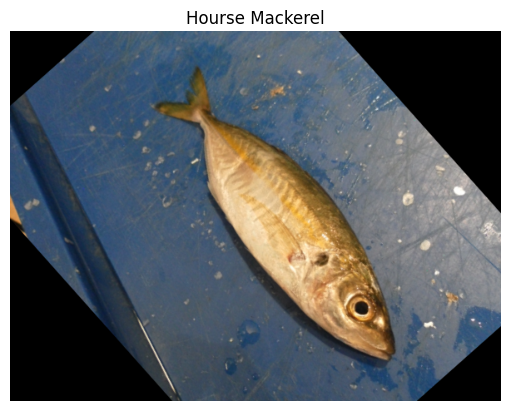

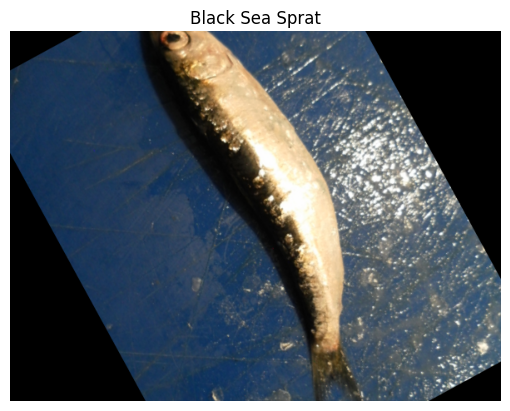

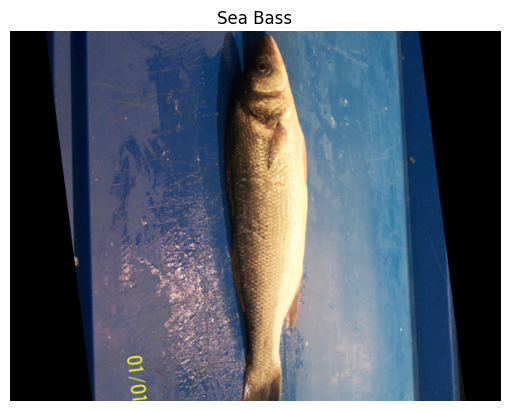

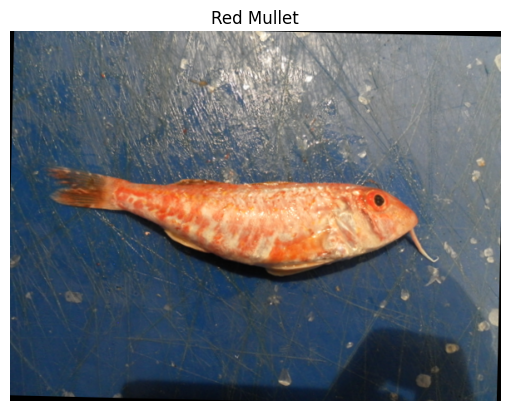

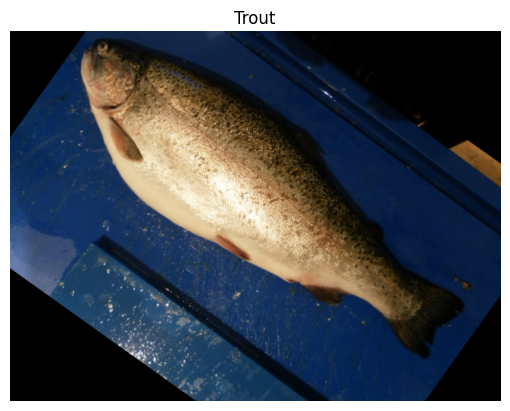

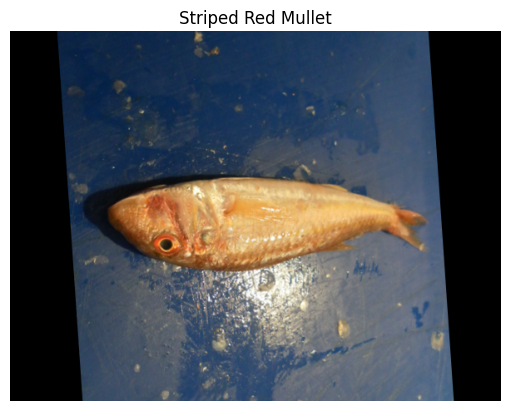

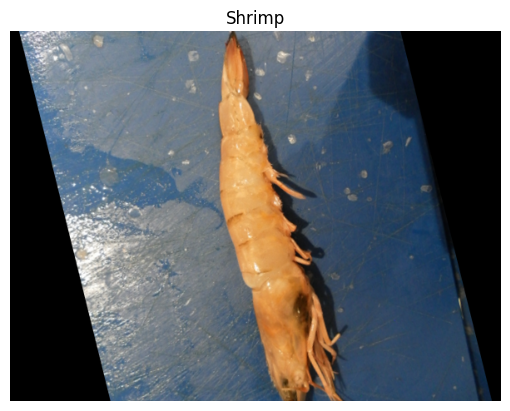

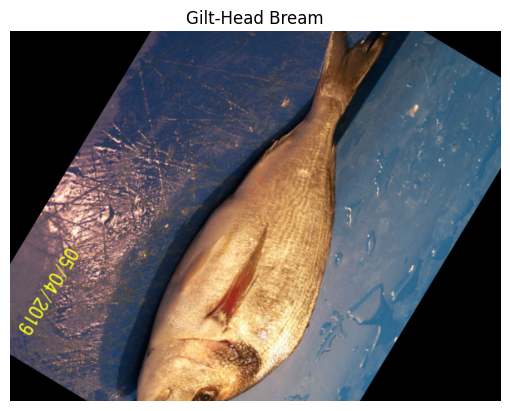

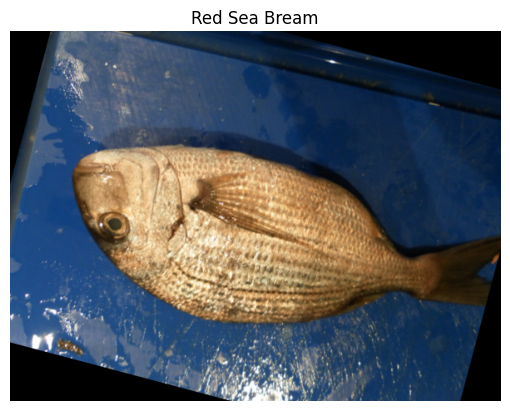

In [6]:
unique_labels = data.drop_duplicates(subset="label")

for i in range(len(unique_labels)):
    img_path = unique_labels["path"].iloc[i]
    label = unique_labels["label"].iloc[i]
    img = mpimg.imread(img_path)
    
    plt.figure()
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
    plt.show()

**2.** Label sayısını alarak kaç adet veri içerdiğini görselleştirdim

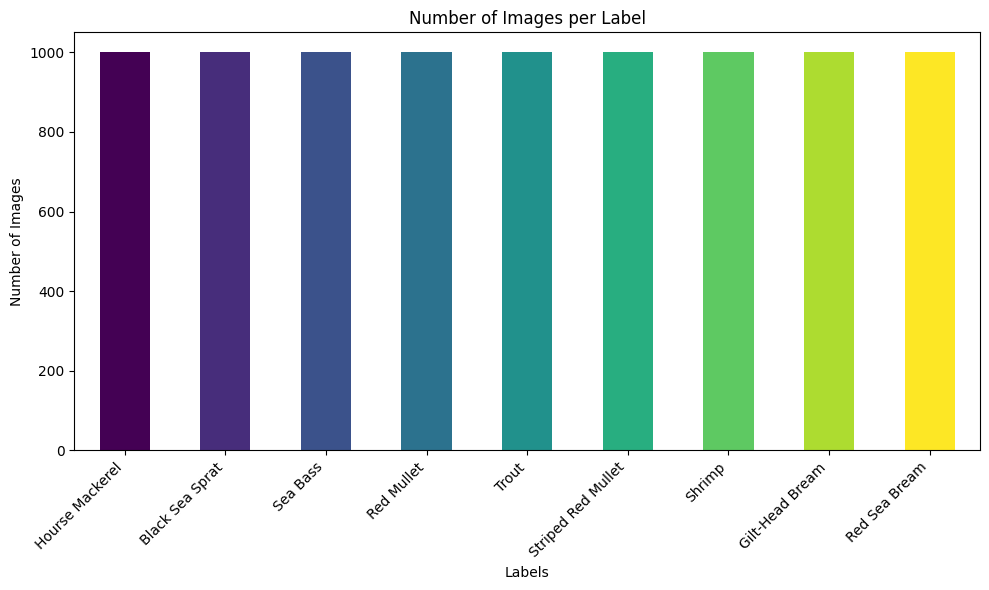

In [7]:
label_counts= data["label"].value_counts()
colors = plt.cm.get_cmap('viridis', len(label_counts)) # her bir bar'ın farkli renkte olmasını istedim:)
plt.figure(figsize=(10,6))
label_counts.plot(kind='bar', color=[colors(i) for i in range(len(label_counts))])
plt.title("Number of Images per Label")
plt.xlabel("Labels")
plt.ylabel("Number of Images")

plt.xticks(rotation=45,ha="right") #Label'lar birbirini engellemesin diye 45 derece sağ döndürülecek.
plt.tight_layout() #Grafiklerin taşmasını engeller.
plt.show()

**One-Hot-Encoding** kullanarak etiketlerimizi kategorize ediyoruz

In [8]:
encoder= OneHotEncoder(sparse=False)
labels_encoded= encoder.fit_transform(data["label"].values.reshape(-1,1))

In [9]:
labels_encoded

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Veri ayrıştırma ile veri setimizi eğitim için train-test olarak ayırıyoruz

In [10]:
X_train,X_test,y_train,y_test= train_test_split(data["path"],labels_encoded,test_size=0.2,random_state=42)

## **Veri Ön İşleme(Image Preprocessing)**

In [11]:
img_size= (128,128)
def preprocessing_img(image_path):
    img=load_img(image_path,target_size=img_size)
    img_array= img_to_array(img)
    img_array= img_array / 255.0 #normalization işlemi
    return img_array
    
#X_train_processed= np.array([preprocessing_img(img) for img in X_train])
#X_test_processed= np.array([preprocessing_img(img) for img in X_test]#) ## hata aldı cpu yetersiz kaldığı için bende thread yöntemi ile çözüm buldum.

In [12]:
from concurrent.futures import ThreadPoolExecutor

def preprocess_images_multithread(img_paths):
    with ThreadPoolExecutor() as executor:
        processed_images = list(executor.map(preprocessing_img, img_paths))
    return np.array(processed_images)

X_train_processed = preprocess_images_multithread(X_train)
X_test_processed = preprocess_images_multithread(X_test)

## **Model Oluşturma**

Modeli oluştururken pek çok farklı kombinasyon denedim ve araştırdım. Sürem kısıtlı olduğu için, en iyi sonuç aldığım modeli aşağıda görebilirsiniz. İlk başta her katmana Dropout eklemeyi düşündüm, ancak bu yöntem iyi sonuçlar vermedi. En iyi sonucu, yalnızca tek bir Dropout katmanı ekleyerek elde ettim. Aktivasyon fonksiyonu olarak “relu” kullandım; bu fonksiyon, negatif değerleri bile 0-1 aralığına getirerek etkili sonuçlar sağlıyor. Çıkış katmanına, etiket sayısı kadar nöron ekledim ve aktivasyon olarak “softmax” kullandım.

In [13]:
model = Sequential()

# Giriş katmanı (Flatten) - Görüntüleri tek bir vektör haline getirme
model.add(Flatten(input_shape=(128, 128, 3)))

model.add(Dense(512, activation='relu'))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  
model.add(Dense(128, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(labels_encoded.shape[1], activation='softmax'))


In [14]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,348,233 (96.70 MB)

 Trainable params: 25,348,233 (96.70 MB)

 Non-trainable params: 0 (0.00 B)

* optimizer=Adam(learning_rate=1e-4): Modelin ağırlıklarını güncellemek için Adam optimizasyon algoritmasını kullanıldı. Öğrenme oranı **1e-4 (0.0001)** olarak ayarlanmış, bu nispeten düşük bir öğrenme oranıdır, modelin daha yavaş ve hassas öğrenmesini sağlar.

* loss='categorical_crossentropy': Kategorik sınıflandırma problemlerinde kullanılan bir kayıp fonksiyonudur. Eğer model çoklu sınıflandırma yapıyorsa (örneğin, birden fazla etiket veya kategori varsa), bu fonksiyon doğru bir seçimdir.

* metrics=['accuracy']: Modelin performansını değerlendirirken doğruluk metriği kullandım. Bu, eğitim ve test aşamalarında modelin doğruluğunu gözlemlemek için kullanılır.

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Early Stopping aşırı öğrenmeyi(overfitting) engellemek adına burada tanımladık 3 adımdada bozulma olursa early stopping yapıyor.

In [16]:
history = model.fit(
    X_train_processed,
    y_train,
    epochs=30,          
    validation_data=(X_test_processed, y_test),
    callbacks=[early_stopping]
    
)

Epoch 1/30


I0000 00:00:1729715510.442400     122 service.cc:145] XLA service 0x7bd024003ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729715510.442457     122 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729715510.442463     122 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 18/225 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1217 - loss: 2.5444

I0000 00:00:1729715514.427566     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.1879 - loss: 2.2284 - val_accuracy: 0.5228 - val_loss: 1.5597
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3773 - loss: 1.6853 - val_accuracy: 0.5594 - val_loss: 1.2572
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5260 - loss: 1.3466 - val_accuracy: 0.6494 - val_loss: 1.0222
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5936 - loss: 1.1437 - val_accuracy: 0.7350 - val_loss: 0.8438
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6752 - loss: 0.9504 - val_accuracy: 0.7817 - val_loss: 0.6687
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7276 - loss: 0.7978 - val_accuracy: 0.7933 - val_loss: 0.5915
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7663 - loss: 0.6844 - val_accuracy: 0.8244 - val_loss: 0.5035
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7999 - loss: 0.5855 - val_accuracy: 0.79

Modelin eğitimini başlatıyoruz ve bir değişkene kaydediyoruz ki sonrasında analizler gerçekleştirebilelim.

In [17]:
# Test seti üzerinde performans değerlendirme
test_loss, test_acc = model.evaluate(X_test_processed, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9585 - loss: 0.1536
Test Loss: 0.12850892543792725, Test Accuracy: 0.9655555486679077


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


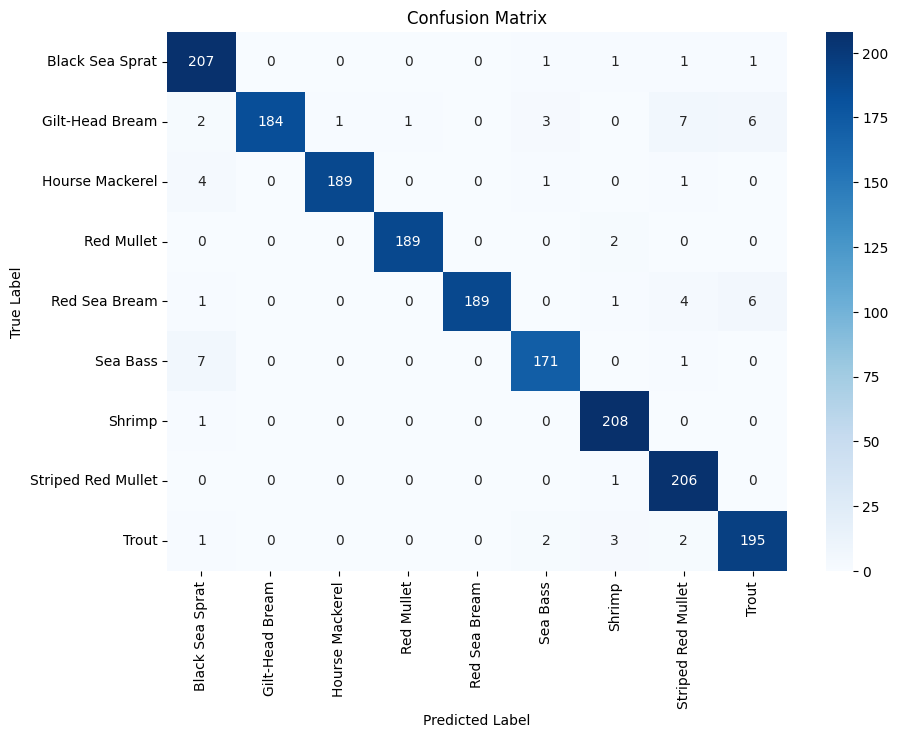

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminleri
y_pred = model.predict(X_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)  # Tahmin edilen sınıfları al
y_true_classes = np.argmax(y_test, axis=1)  # Gerçek sınıflar

# Confusion matrix hesaplama
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Confusion Matrix'i görselleştirme
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix")
plt.show()



Modelmizi kullanarak X_text olarka ayırdığımız veriler üzerinde tahmin gerçekleştiriyoruz ve Confusion Matrix ile görselleştirme yapıyoruz.

In [19]:

# Classification Report - precision, recall, f1-score
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       211
           1       1.00      0.90      0.95       204
           2       0.99      0.97      0.98       195
           3       0.99      0.99      0.99       191
           4       1.00      0.94      0.97       201
           5       0.96      0.96      0.96       179
           6       0.96      1.00      0.98       209
           7       0.93      1.00      0.96       207
           8       0.94      0.96      0.95       203

    accuracy                           0.97      1800
   macro avg       0.97      0.97      0.97      1800
weighted avg       0.97      0.97      0.97      1800



In [20]:
# F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f'F1 Score: {f1}')

F1 Score: 0.9655583756153114


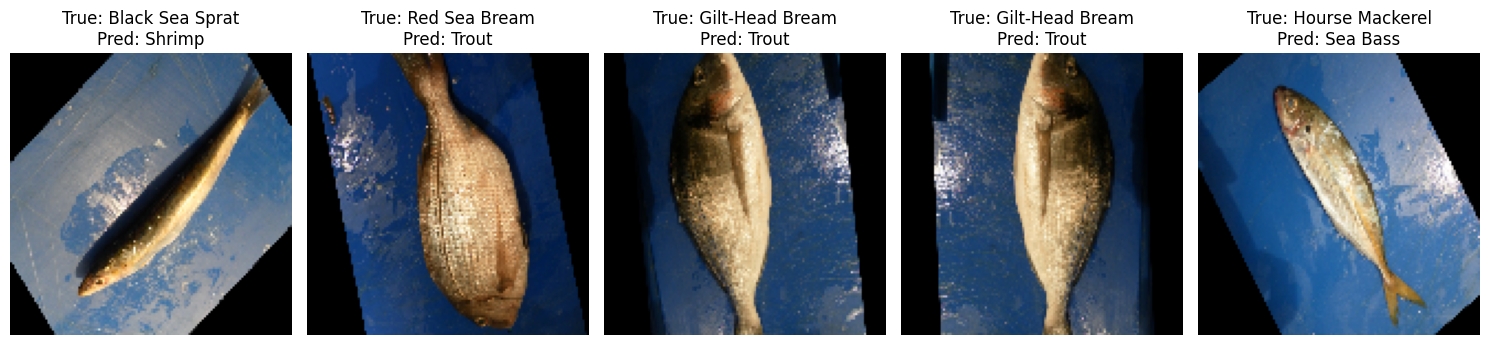

In [21]:
# Yanlış tahmin edilen indeksleri bulma
incorrect_indices = np.where(y_pred_classes != y_true_classes)[0]

# Yanlış tahmin edilen ilk birkaç örneği görselleştirme
num_examples = 5  # Kaç tane yanlış tahmin edilen görüntü sayısı
plt.figure(figsize=(15, 10))
for i, idx in enumerate(incorrect_indices[:num_examples]):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(X_test_processed[idx].reshape(128, 128, 3))  # Görüntülerin boyutunu ayarlayın
    plt.title(f"True: {encoder.categories_[0][y_true_classes[idx]]}\nPred: {encoder.categories_[0][y_pred_classes[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

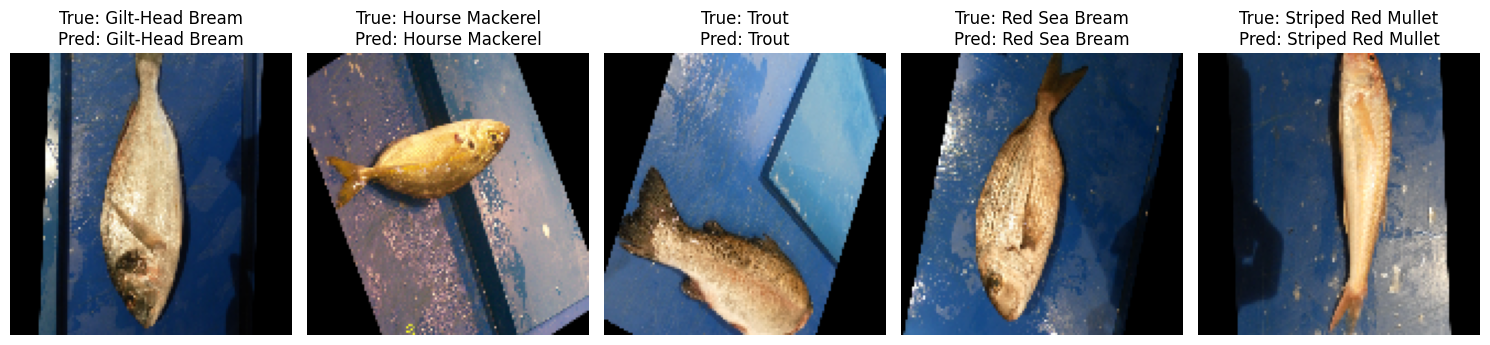

In [22]:
# Doğru tahmin edilen indeksleri bulma
correct_indices = np.where(y_pred_classes == y_true_classes)[0]

# Doğru tahmin edilen ilk birkaç örneği görselleştirme
plt.figure(figsize=(15, 10))
for i, idx in enumerate(correct_indices[:num_examples]):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(X_test_processed[idx].reshape(128, 128, 3))  # Görüntülerin boyutunu ayarlayın
    plt.title(f"True: {encoder.categories_[0][y_true_classes[idx]]}\nPred: {encoder.categories_[0][y_pred_classes[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()